# Example of working with HYCOM output available on the hycom.org tds

In [10]:
# Import packages we'll need
import netCDF4
import matplotlib.pyplot as plt
import numpy as np 
import datetime as dt  # Python standard library datetime  module
import math as math
from pylab import quiver
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [11]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [12]:
# open pipes to hycom output
url='http://tds.hycom.org/thredds/dodsC/GLBa0.08/expt_91.1/2015'
nc=netCDF4.Dataset(url)
print 'Available variables are: ' +  str(nc.variables.keys())

Available variables are: [u'Y', u'X', u'MT', u'Date', u'Depth', u'Latitude', u'Longitude', u'qtot', u'emp', u'surface_temperature_trend', u'surface_salinity_trend', u'ssh', u'mld', u'mlp', u'salinity', u'temperature', u'u', u'v']


In [13]:
print nc

<type 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.0
    title: HYCOM GLBa0.08
    institution: Naval Research Laboratory
    source: HYCOM archive file
    experiment: 91.1
    history: archv2ncdf2d for run date 2015053018
    dimensions(sizes): Depth(33), MT(158), X(4500), Y(3298)
    variables(dimensions): int32 Y(Y), int32 X(X), float64 MT(MT), float64 Date(MT), float32 Depth(Depth), float32 Latitude(Y,X), float32 Longitude(Y,X), float32 qtot(MT,Y,X), float32 emp(MT,Y,X), float32 surface_temperature_trend(MT,Y,X), float32 surface_salinity_trend(MT,Y,X), float32 ssh(MT,Y,X), float32 mld(MT,Y,X), float32 mlp(MT,Y,X), float32 salinity(MT,Depth,Y,X), float32 temperature(MT,Depth,Y,X), float32 u(MT,Depth,Y,X), float32 v(MT,Depth,Y,X)
    groups: 



In [14]:
# create variables for u,v,x,y,depth
lon=nc.variables['Longitude']
lat=nc.variables['Latitude']
latmin = np.mean(lat)  # needed for scaling lon/lat plots
depth=nc.variables['Depth']

lon_d=lon[1,:]
lat_d=lat[:,1]
depth_d=depth[:]

# extrat subgrid
lon1=262
lon2=295
lat1=7
lat2=32

ilon1=find_nearest_idx(lon_d, lon1)
ilon2=find_nearest_idx(lon_d, lon2)
ilat1=find_nearest_idx(lat_d, lat1) 
ilat2=find_nearest_idx(lat_d, lat2)

lon_d=lon_d[ilon1:ilon2]
lat_d=lat_d[ilat1:ilat2]

# create grid for plotting
lons,lats = np.meshgrid(lon_d,lat_d)


In [15]:
# specify time level
it=1
Time=nc.variables['Date']
print Time
time=Time[it]
print time

<type 'netCDF4.Variable'>
float64 Date(MT)
    long_name: date
    units: day as %Y%m%d.%f
    C_format: %13.4f
    FORTRAN_format: (f13.4)
unlimited dimensions: 
current shape = (158,)
filling off

20150102.0


In [16]:
# 
var1_name='ssh'
var1=nc.variables[var1_name]

var1_d=var1[it,ilat1:ilat2,ilon1:ilon2]
vmin=var1_d.min()
vmax=var1_d.max()

# This min/max calc won't work in general, but is OK for data relatively well distributed about 0
vminmax=math.ceil(2*max(abs(vmin),abs(vmax)))/2
print vmin,vmax,vminmax

-0.481657 0.547775 1.0


In [17]:
ilev=1   # specify vertical level to extract
uvel_name='u'
uvel=nc.variables[uvel_name]
uvel_d=uvel[it,ilev,ilat1:ilat2,ilon1:ilon2]
uvel_min=uvel_d.min()
uvel_max=uvel_d.max()
print uvel_min,uvel_max
vvel_name='v'
vvel=nc.variables[vvel_name]
vvel_d=vvel[it,ilev,ilat1:ilat2,ilon1:ilon2]
vvel_min=vvel_d.min()
vvel_max=vvel_d.max()
print vvel_min,vvel_max

-1.16985 1.53663
-1.83487 1.65058


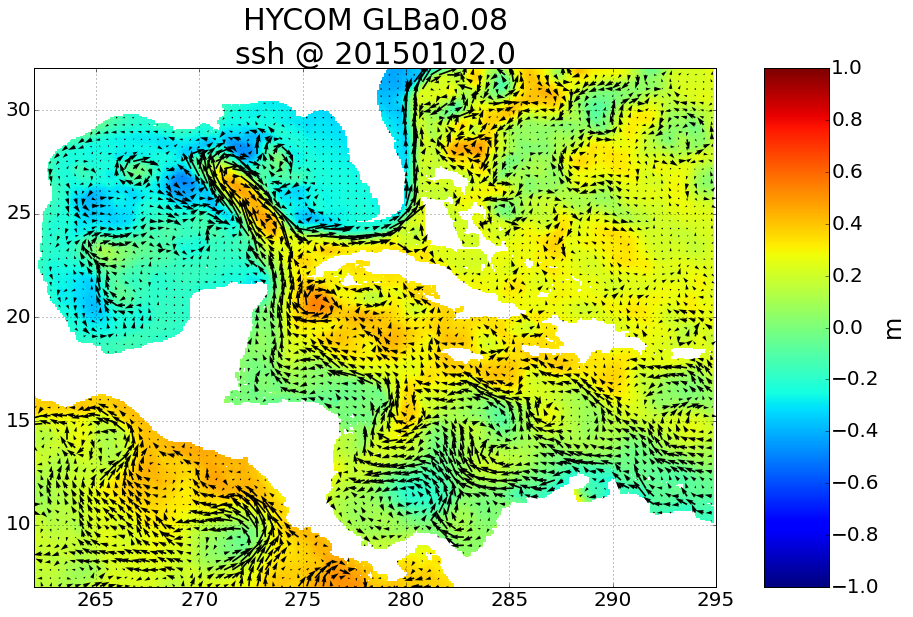

In [21]:
# Let's plot ssh, for a test
fig = plt.figure(figsize=(18,9), dpi=144)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
ax.set_aspect(1.0/np.cos(latmin * np.pi / 180.0))

pc=plt.pcolormesh(lons, lats, var1_d, cmap=plt.cm.jet, vmin=-vminmax, vmax=vminmax)
plt.title("%s\n%s @ %s" % (nc.title, var1_name, time), fontsize=30)
plt.grid(True)
plt.xlim((lon1,lon2))
plt.ylim((lat1,lat2))
plt.tick_params(axis='both', which='major', labelsize=20)

ivecstride=5

Q = quiver(lons[::ivecstride, ::ivecstride],lats[::ivecstride, ::ivecstride], 
           uvel_d[::ivecstride , ::ivecstride], vvel_d[::ivecstride, ::ivecstride], angles='xy',scale_units='xy',scale=1)

# add colorbar
cbax = fig.add_axes([0.80, 0.1, 0.05, 0.8]) 
cb = plt.colorbar(pc, cax=cbax,  orientation='vertical')
cb.set_label(var1.units, fontsize=24)
cb.ax.tick_params(axis='both', which='major', labelsize=20)